In [33]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import uniform as uniform

plt.rcParams["figure.figsize"] = (25,8)

# mackey glass

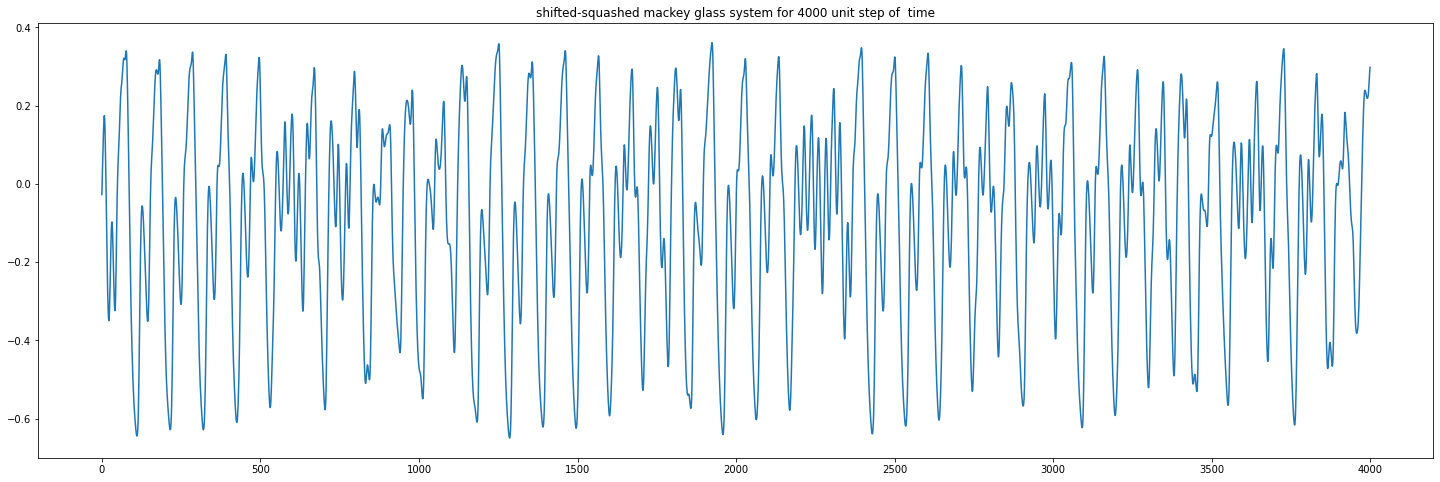

In [37]:
alpha = 0.2 
beta = 10 
gamma = 0.1 
tha = 30
delta = 0.1

initialTransition = 10000
time = 4000 + initialTransition

y = uniform(0 , 1 ,size = int((time/delta))) 

for i in range(len(y)):
  y [i] = y [i-1] + delta * ( ((alpha * y[int(i-tha/delta)]) / (1+y[int(i-tha/delta)]**beta)) - gamma*y[i-1] )

mackey = np.tanh(y[::int(1/delta)][initialTransition:] - 1)

plt.title('shifted-squashed mackey glass system for {} unit step of  time'.format(time - initialTransition))
plt.plot(np.arange(len(mackey)), mackey )
plt.show()

time = time - initialTransition  # for future use 

In [38]:
lenght_sequence = 2000
lag_between_input_output = 60
test_size = 500  

input_  = mackey [:lenght_sequence] .reshape((-1,1))
# input_ =  np.ones((lenght_sequence , 1)) 
test_input_ = mackey [:lenght_sequence + test_size] .reshape((-1,1))
# test_input_ =  np.ones((lenght_sequence+ test_size , 1)) 

output_ = mackey [lag_between_input_output : lenght_sequence+lag_between_input_output].reshape((-1,1))
test_output_ = mackey [lag_between_input_output : test_size+lenght_sequence+lag_between_input_output].reshape((-1,1))


print('shape input = ', input_.shape)
print('shape output = ', output_.shape)
print('shape test input = ', test_input_.shape)
print('shape test output = ', test_output_.shape)

shape input =  (2000, 1)
shape output =  (2000, 1)
shape test input =  (2500, 1)
shape test output =  (2500, 1)


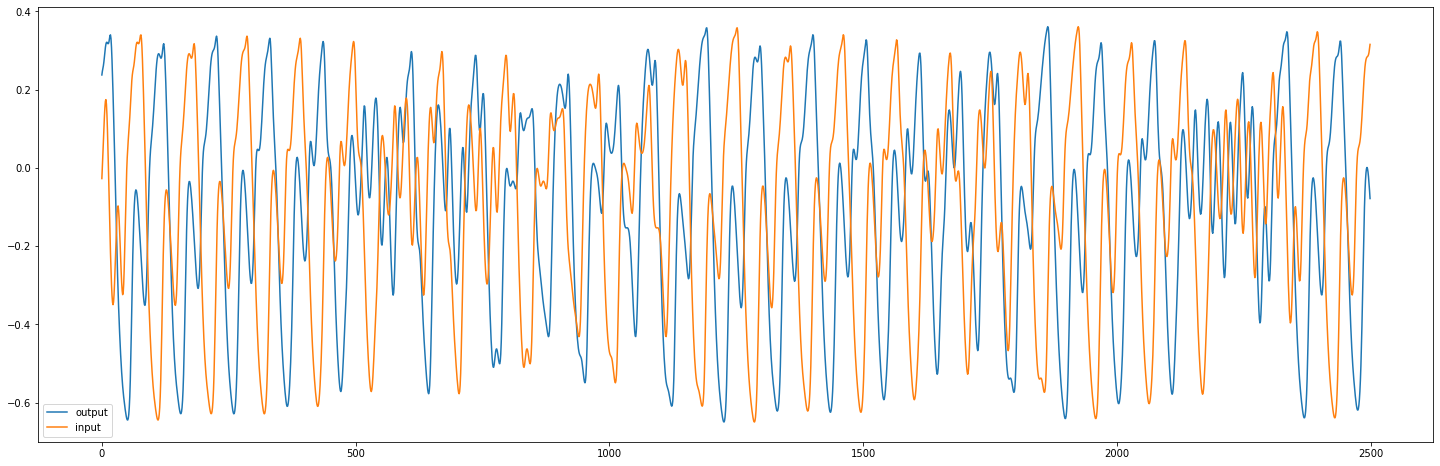

In [39]:
plt.plot(np.arange(test_output_.shape[0]),test_output_ , label = 'output')
plt.plot(np.arange(test_output_.shape[0]),test_input_ , label = 'input')
plt.legend()
plt.show()

# model

In [54]:
input_dim = input_.shape[1]
output_dim = output_.shape[1]

noise_maximum_value =  1e-5

g  = 1.5
num_reservoir = 1000

time_constant = 10
leak_rate     = 1

max_w_in = 1
max_w_back = 5

sparsity_percentage_w_in = 0.5
sparsity_percentage_w_back = 0.5
sparsity_percentage_reservoir  = 0.95

w_in = uniform(low = - max_w_in , high = max_w_in , size =(input_dim,num_reservoir)) 
w_in[uniform(low = 0 , high = 1 , size =w_in.shape)  < sparsity_percentage_w_in ] = 0

# w    = uniform(low = - 1 , high = 1 , size =(num_reservoir,num_reservoir))  
w    = np.random.normal(0 , 1 , size =(num_reservoir,num_reservoir))  
w[uniform(low = 0 , high = 1 , size =w.shape)  < sparsity_percentage_reservoir] = 0
w  = g * w / np.sqrt(num_reservoir *(1-sparsity_percentage_reservoir))

w_back = uniform(low = -max_w_back , high = max_w_back , size =(output_dim,num_reservoir))   
# w_back = np.random.normal(0 , (1-sparsity_percentage_w_back)*num_reservoir , size =(output_dim,num_reservoir))   
w_back [uniform(low = 0 , high = 1 , size =w_back.shape)  < sparsity_percentage_w_back] = 0

w_readout = uniform(low = -0.1 , high = 0.1 , size =(num_reservoir,output_dim) ) * 0.5

def noise(low = -noise_maximum_value , high =noise_maximum_value , size =(1,num_reservoir))  : 
  return uniform(low = -noise_maximum_value , high =noise_maximum_value , size =(1,num_reservoir)) 

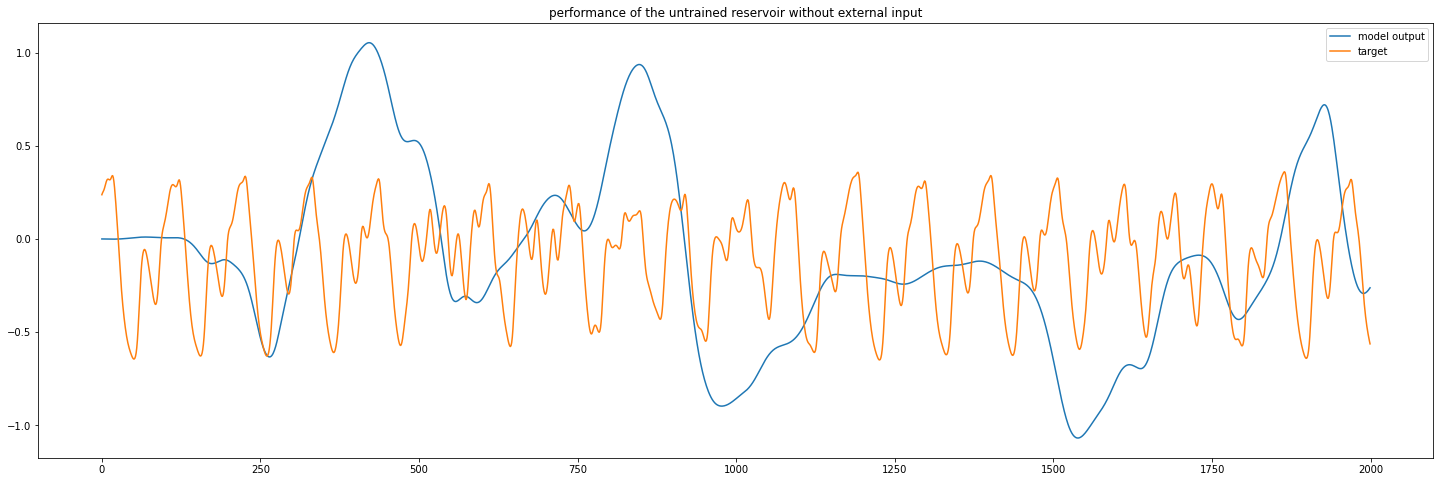

In [55]:
trainsize = len(input_)  #trainsize is to denote how much of data to use to train the model

X = uniform(-1 , 1, size = (trainsize,num_reservoir)) * 0.01
preds = np.zeros((trainsize , w_readout.shape[-1]))

x = 0
for step in range(trainsize) : 
  dx =  (- leak_rate * x  + (X[[step-1]] @ w)  ) / time_constant
  x = x + dx
  X[[step]] =   np.tanh(x) # + noise()               

  pred = (X[[step]]@ w_readout)
  preds [[step]] =  pred 

plt.plot(np.arange(trainsize), preds , label='model output' )
plt.plot(np.arange(trainsize), output_ , label= 'target')
plt.title('performance of the untrained reservoir without external input')
plt.legend()
plt.show()

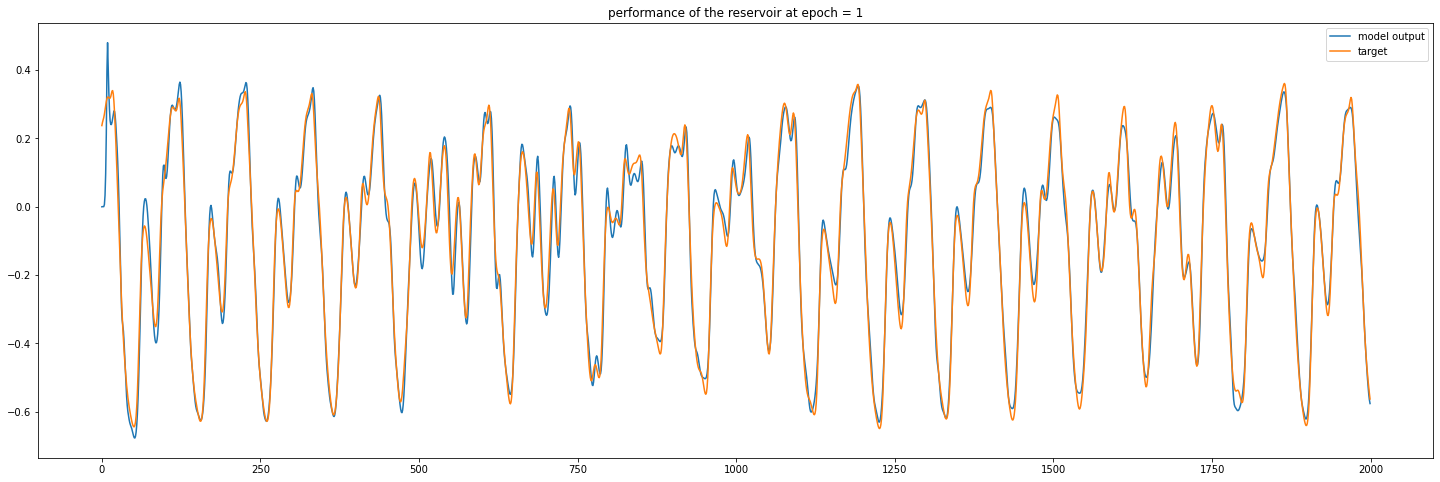


 weight change = 0.3181088067033898 
 
 rmse epoch = 0.03609924753624628 



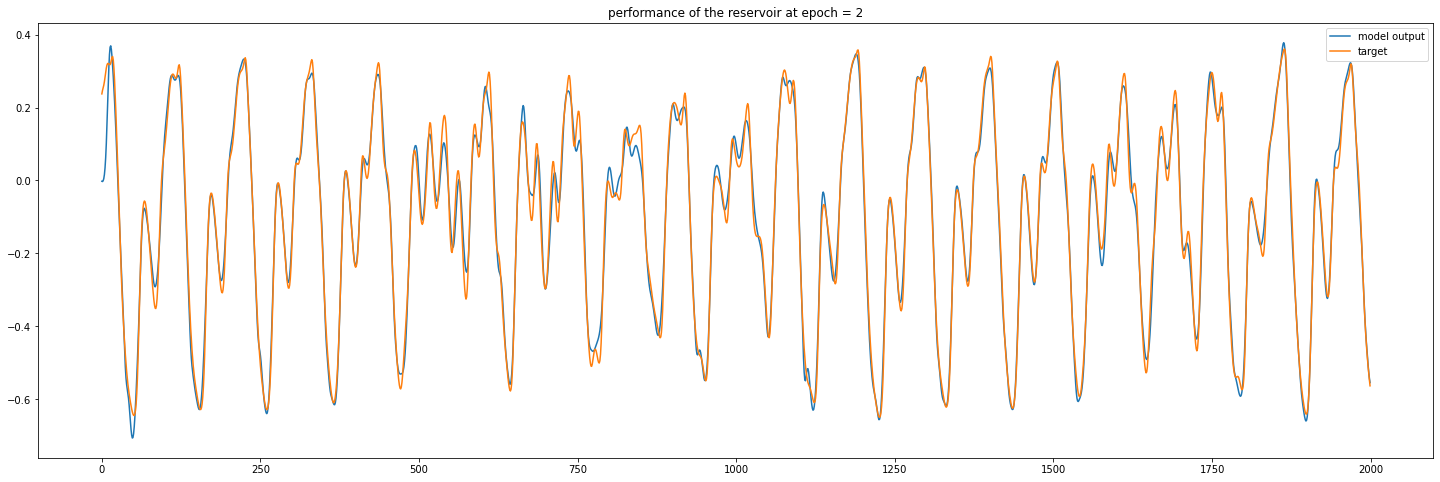


 weight change = 0.2005322402892342 
 
 rmse epoch = 0.031616134509137334 



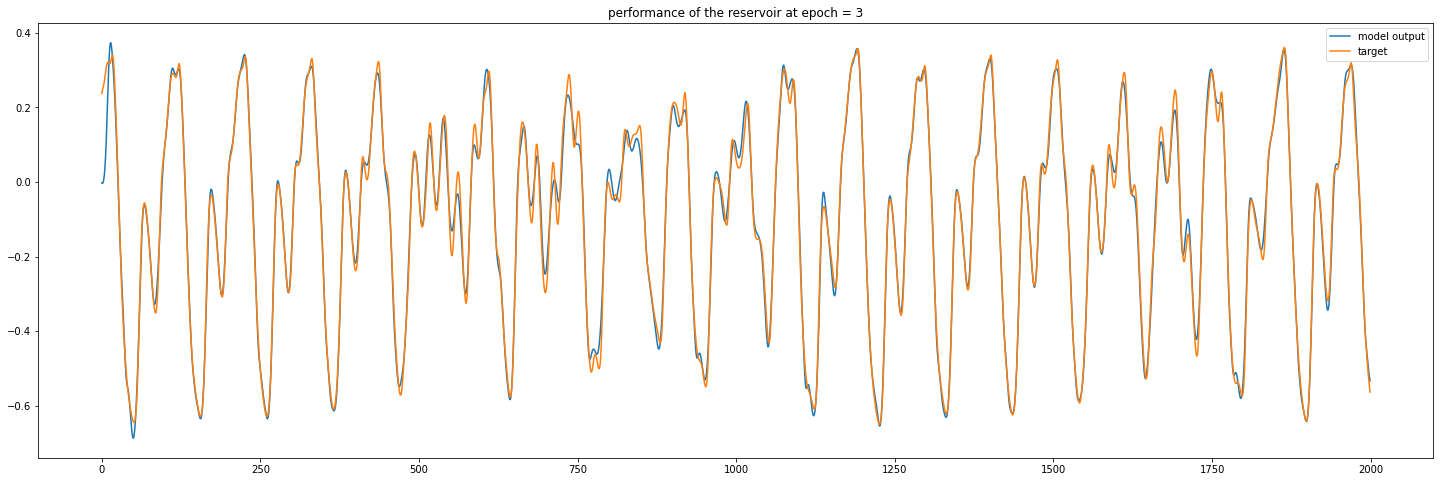


 weight change = 0.1184599523833443 
 
 rmse epoch = 0.02685217080403779 



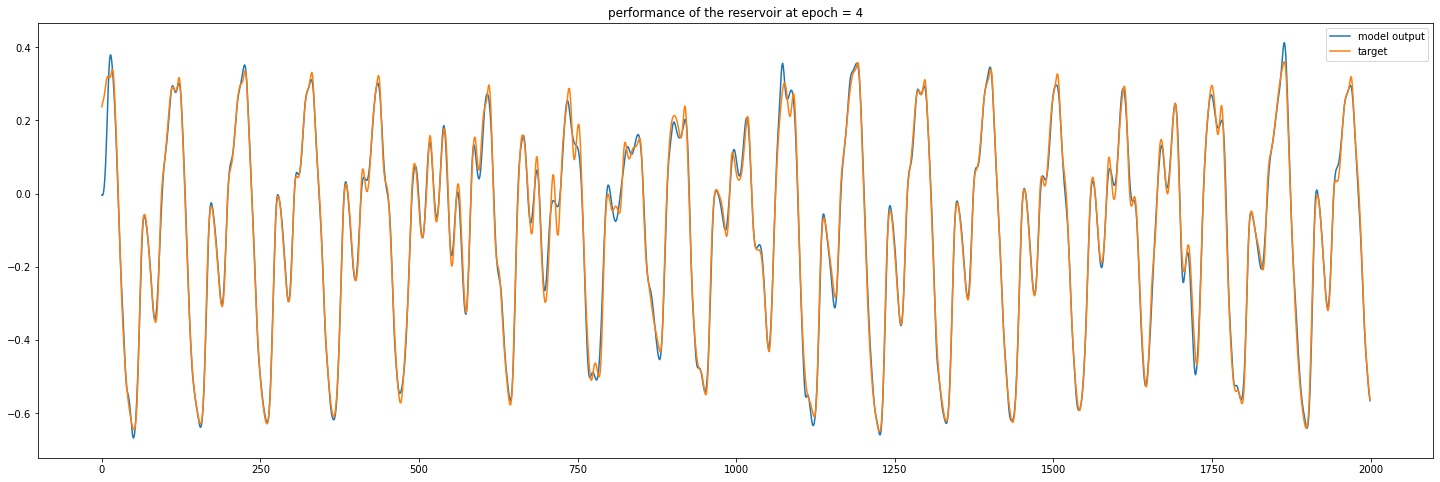


 weight change = 0.0976257295664222 
 
 rmse epoch = 0.025292137736896876 



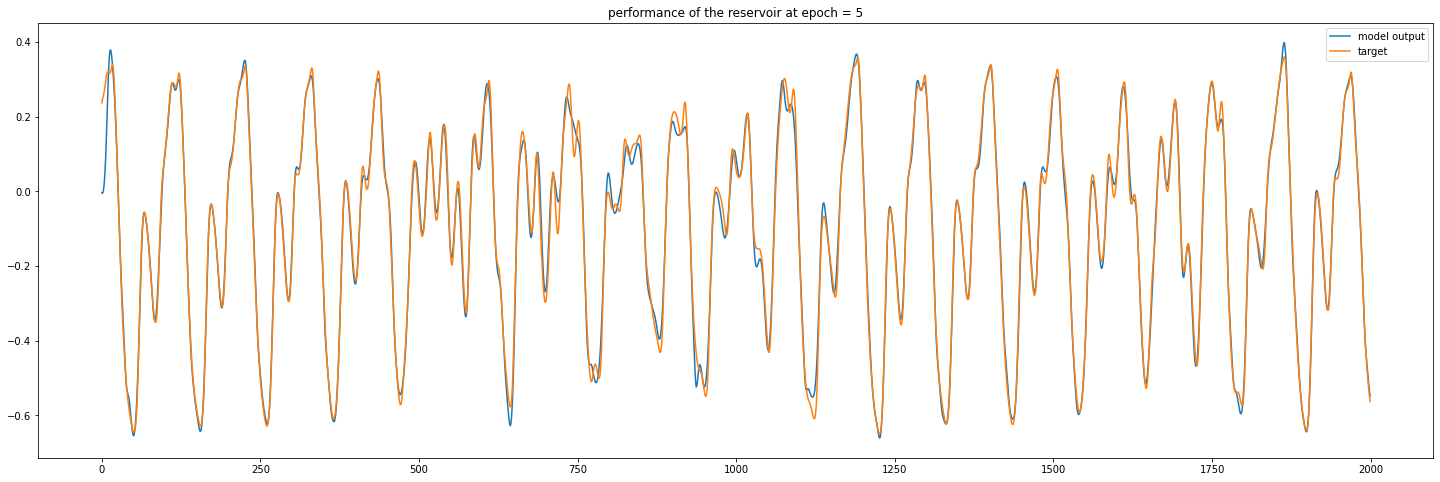


 weight change = 0.1090819535365652 
 
 rmse epoch = 0.02665325310914151 



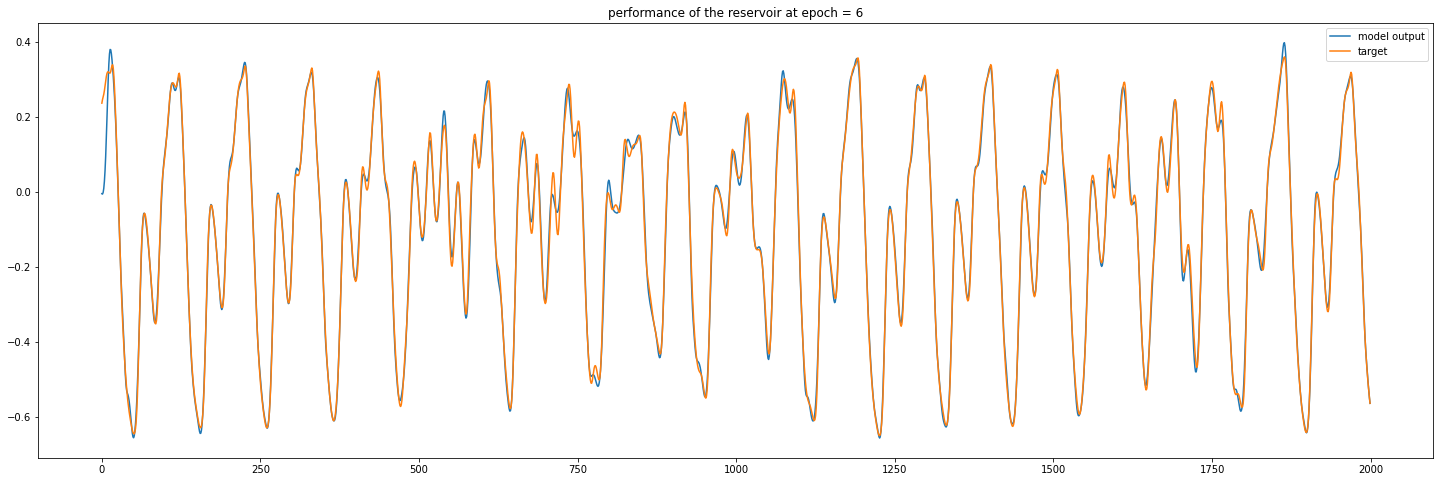


 weight change = 0.058217543982993246 
 
 rmse epoch = 0.02196006629460367 



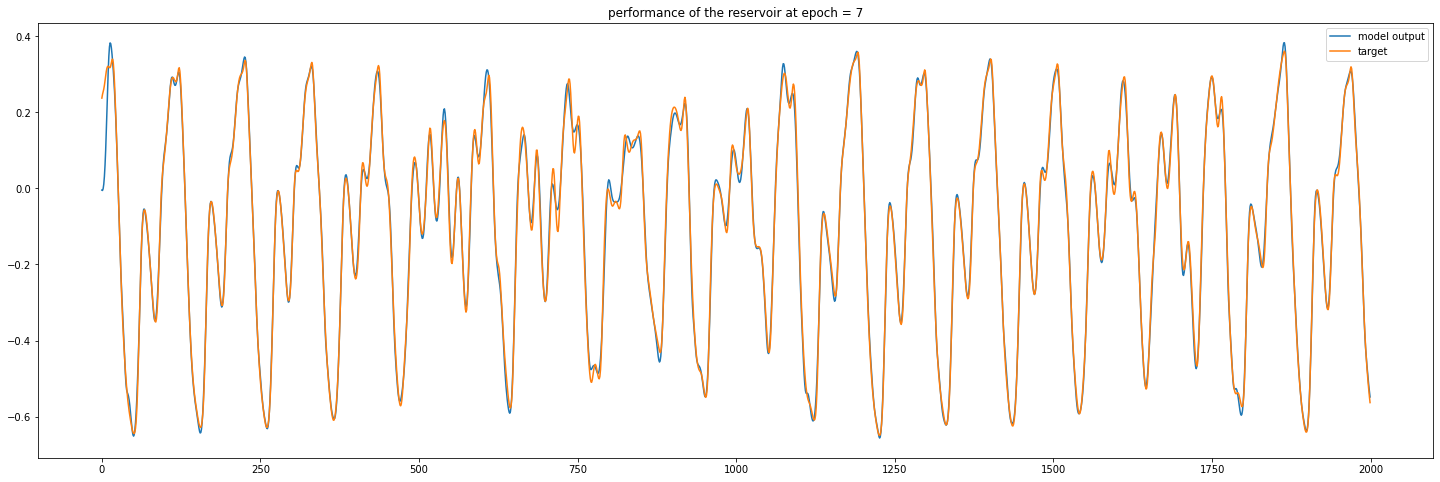


 weight change = 0.049133776488404036 
 
 rmse epoch = 0.02097404861394376 



In [56]:
change_w = np.inf 
update_step = 1
change_threshold = 0.05 
show_frq = 1
alpha = 1
epoch = 0 

p = np.identity(num_reservoir) / alpha

while change_w/ num_reservoir > change_threshold :
    preds = np.zeros((trainsize , w_readout.shape[-1]))
    X = np.zeros((trainsize , num_reservoir))

    epoch += 1
    mse = 0
    change_w = 0
    x = 0
    for step in range(trainsize) :
        dx =  (- leak_rate * x  + (X[[step-1]] @ w) + input_[[step]] @ w_in + preds[[step-1]] @ w_back ) / time_constant
        x = x + dx
        X[[step]] =   np.tanh(x) # + noise()               

        pred = (X[[step]]@ w_readout)
        preds [[step]] =  pred 
        error = pred - output_[[step]]
        mse += error ** 2

        pr = p @ (X[[step]].T)
        rpr = (X[[step]]) @ pr
        cc = 1/(1+rpr)
        p -= pr @ pr.T * cc 
        dw = - error * (pr @ cc)

        change_w += np.sum(np.abs(dw))
        w_readout += dw

    rmse = (mse / trainsize) ** 0.5
    
    if  epoch % show_frq == 0 :
      plt.plot(np.arange(trainsize), preds , label='model output' )
      plt.plot(np.arange(trainsize), output_ , label= 'target')
      plt.title('performance of the reservoir at epoch = {}'.format(epoch))
      plt.legend()
      plt.show()

      print('\n weight change = {} \n '.format(change_w/ num_reservoir))
      print(' rmse epoch = {} \n'.format(rmse[0,0]))

In [58]:
testsize = len(test_input_)
preds = np.zeros((testsize , w_readout.shape[-1]))

# np.random.seed(4)
# X = uniform(-0.01 , 0.01 , size = (testsize,num_reservoir)) 
X = np.zeros( (testsize,num_reservoir) )
teacher_startup =  1000

x = 0 
for step in range(testsize):
    if step < teacher_startup  : 
      dx =  (- leak_rate * x  + (X[[step-1]] @ w) + test_input_[[step]] @ w_in + test_output_[[step-1]] @ w_back ) / time_constant
      x = x + dx
      X[[step]] =   np.tanh(x) # + noise()               
      preds [[step]] = X[[step]] @ w_readout
    
    else :  
      dx =  (- leak_rate * x  + (X[[step-1]] @ w) + test_input_[[step]] @ w_in + preds[[step-1]] @ w_back ) / time_constant
      x = x + dx
      X[[step]] =   np.tanh(x) # + noise()               
      preds [[step]] = X[[step]] @ w_readout

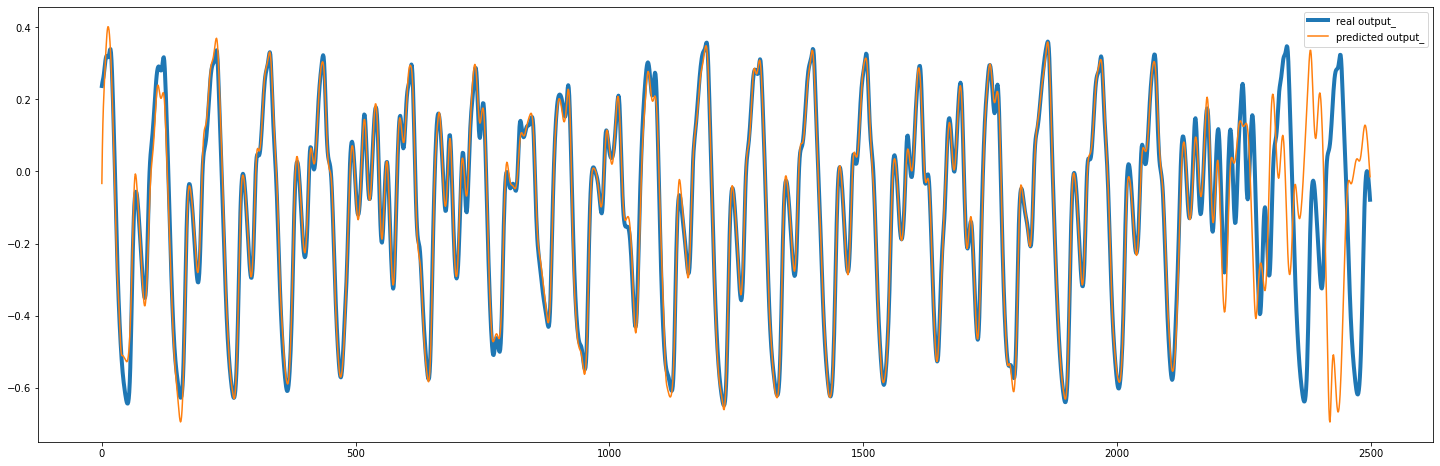


length train = 2000 , length test = 500 

rmse train =  0.02618648258961831
rmse test =  0.3161611190599248


In [59]:
from_step  = 0 # discard 
to_step = testsize
time = len(test_input_)

plt.plot(np.arange(time)[from_step :to_step],test_output_[from_step :to_step] , label = 'real output_' , linewidth = '4')
plt.plot(np.arange(time)[from_step :to_step],preds[from_step :to_step], label = 'predicted output_' )
plt.legend()  
plt.show()    

print('\nlength train = {} , length test = {} \n'.format(trainsize, test_size))
print('rmse train = ', (np.sum((preds[:trainsize] - test_output_[:trainsize] )**2) /trainsize)**0.5 ) 
print('rmse test = ', (np.sum(np.abs(preds[trainsize:] - test_output_[trainsize:] )**2) / (time-trainsize))**0.5 )